In [1]:
import pickle

import matplotlib.pyplot as plt
import numpy as np

In [12]:
# with open('/sciclone/geograd/stmorse/reddit/embeddings/embeddings_2009-03.npz', 'rb') as f:
#     embedding0 = np.load(f)

# with open('/sciclone/geograd/stmorse/reddit/embeddings/embeddings_2009-04.npz', 'rb') as f:
#     embedding1 = np.load(f)

with open('/sciclone/geograd/stmorse/reddit/test/tfidf_mbkm_80/tfidf_2011-03.pkl', 'rb') as f:
    tfidf0 = pickle.load(f)

with open('/sciclone/geograd/stmorse/reddit/test/tfidf_mbkm_80/tfidf_2011-04.pkl', 'rb') as f:
    tfidf1 = pickle.load(f)

with open('/sciclone/geograd/stmorse/reddit/test/maps_mbkm_80/maps_2011-03.pkl', 'rb') as f:
    output = pickle.load(f)

In [13]:
tfidf0.keys(), output.keys()

(dict_keys(['year', 'month', 'full', 'tfidf']),
 dict_keys(['year', 'month', 'cluster_map', 'similarity']))

In [14]:
tfidf0['tfidf'][0].keys()

dict_keys(['sample_indices', 'keywords'])

In [15]:
n0 = len(tfidf0['tfidf'])

for i in range(5):
    print(i)
    print(tfidf0['tfidf'][0]['keywords'])
    idx = np.where(output['similarity'][i] > 0)[0]
    for j in idx:
        print(f'  {j}: {output['similarity'][i,j]:.3f} -- {tfidf1['tfidf'][j]['keywords']}')

0
['verdun' 'neighbourhood' 'ville' 'neighbourhoods' 'assistance' 'ram'
 'pasted' 'premiums' 'montréal' 'lasalle' 'lots' 'blame' 'shotguns'
 'corgi' 'star' 'ive' 'mildly' 'expanded' 'royal' 'hunting']
  31: 0.026 -- ['lein' 'steam' 'gmail' 'gulf' 'address' 'servers' 'videos' 'tlpd' '15kg'
 'helloworld' 'gfwl' 'mail' 'lots' 'cake' 'jref' 'attraction' 'expenses'
 'leiningen' 'letter' 'ramp']
1
['verdun' 'neighbourhood' 'ville' 'neighbourhoods' 'assistance' 'ram'
 'pasted' 'premiums' 'montréal' 'lasalle' 'lots' 'blame' 'shotguns'
 'corgi' 'star' 'ive' 'mildly' 'expanded' 'royal' 'hunting']
  6: 0.026 -- ['nostalgia' 'speaking' 'photo' 'regenerations' 'lords' 'stays' 'vortex'
 'infrastructure' 'c3' 'dolphin' 'resource' 'limited' 'device' 'choke'
 'sites' 'baseball' 'limits' 'wormhole' 'avp' 'dove']
  30: 0.026 -- ['israel' 'fw' 'hamas' 'gaza' 'actions' 'palestinian' 'giants'
 'acknowledge' 'psychology' 'eliminate' 'fishing' 'lane' 'functions'
 'violent' 'colfax' 'scold' 'adjustment' 'bos' 

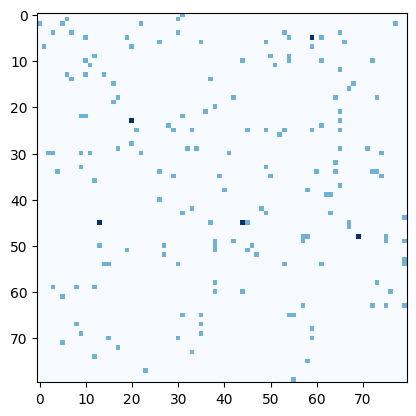

In [16]:
plt.imshow(output['similarity'], cmap='Blues', vmin=0, vmax=np.amax(output['similarity']))